# Tracking a Panda in a Bamboo Grove: Exponential Smoothing vs. Running Mean

#### Team members: Areeba Hashmi, Hifza Ijaz, Denis Boborukhin, Skoltech, 2025  

\
The simulation of a panda's stepwise random walk, noisy measurement generation, noise variance identification using residuals, calculation of optimal exponential smoothing coefficient, smoothing, and visualization.

## Part 1. Calm walk

### 1-2. Generate the panda's true trajectory. Generate noisy measurements
Simulate the true position trajectory $X_i$ using the random walk model:

$X_i = X_{i-1} + w_i$, where $w_i \sim \mathcal{N}(0, \sigma_w^2)$ -- normally distributed noise.

$z_i = X_i + \eta_i$, where $\eta_i \sim \mathcal{N}(0, \sigma_\eta^2)$ with .

Parameters:
- $\sigma_w^2 = 12$
- $\sigma_\eta^2 = 9$
- Initial position $X_1 = 10$ m

In [481]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_random_walk(n_points, sigma_w_sq, sigma_eta_sq, init_pos=10, fig_num=None):
    wi = np.random.normal(0, np.sqrt(sigma_w_sq), n_points)
    Xi = np.zeros(n_points)
    Xi[0] = init_pos
    for i in range(1, n_points):
        Xi[i] = Xi[i-1] + wi[i]
    eta = np.random.normal(0, np.sqrt(sigma_eta_sq), n_points)
    z = Xi + eta

    if fig_num:
        plt.figure(figsize=(8,5))
        plt.plot(Xi, label='True Trajectory', linewidth=1)
        plt.plot(z, label='Noisy Measurements', alpha=0.6, linewidth=1)
        plt.xlabel('Step')
        plt.ylabel('Position (m)')
        plt.title(f'Panda Trajectory (n = {n_points})')
        plt.suptitle(f'Figure {fig_num}: Panda Trajectory (n = {n_points})', fontsize=16, y=0.005)
        plt.legend()
        plt.grid()
        plt.show()

    return Xi, z, wi, eta

sigma_w_sq = 12
sigma_eta_sq = 9
init_pos = 10

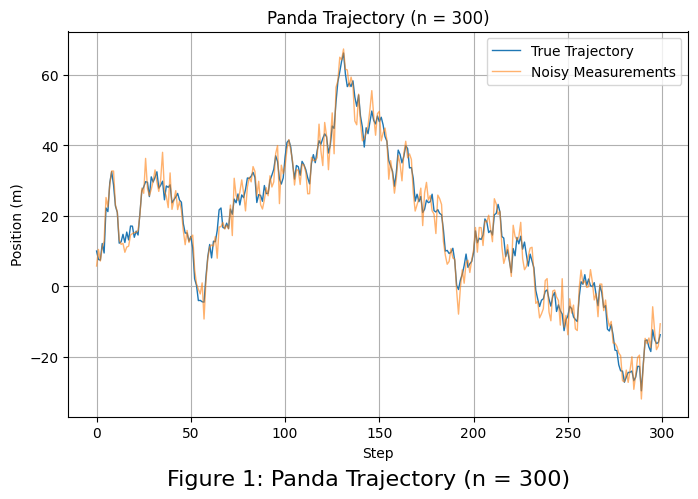

In [482]:
res_300  = simulate_random_walk(n_points=300 , sigma_w_sq=sigma_w_sq, sigma_eta_sq=sigma_eta_sq, init_pos=init_pos, fig_num=1)

Fig 1 represents a random walk for 300-time steps which show the movement of panda in a bamboo grove. Addition of the noise measurements is depicted by the fluctuations around the true trajectory. The overall trend of movement is quite clear showing the irregularities leading to a less smooth estimated path. 


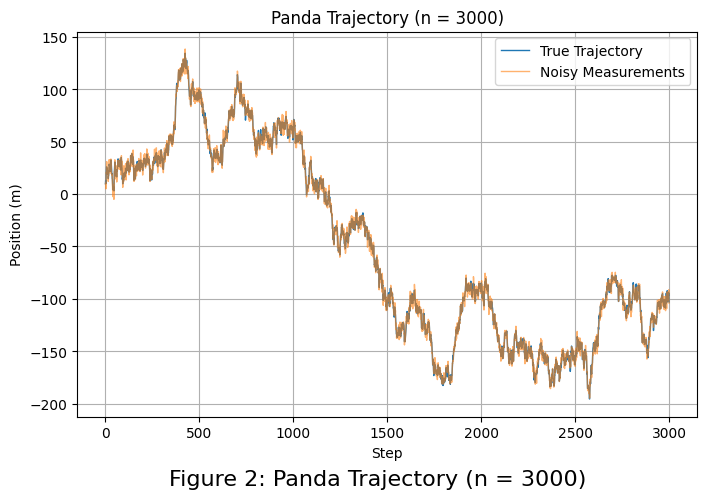

In [483]:
res_3000 = simulate_random_walk(n_points=3000, sigma_w_sq=sigma_w_sq, sigma_eta_sq=sigma_eta_sq, init_pos=init_pos, fig_num=2)

Fig 2 represents panda’s long-term movement up to 3000 steps; the larger dataset allows overall trend to become clearer even in the presence of noise. There is a close alignment between true and measured path which indicate the impact of noise is small as compared to total displacement. 

### 3. Identify process and measurement noise variances

#### The system:
- $E[v^2]$ = $\sigma_w^2$ + $2*\sigma_\eta^2$
- $E[p^2]$ = $2 * \sigma_w^2$ + $2*\sigma_\eta^2$

In [484]:
def identify_noise_variances(wi, eta):
    v = wi[1:] + eta[1:] - eta[:-1]
    E_v2 = np.mean(v**2)

    p = wi[2:] + wi[1:-1] + eta[2:] - eta[:-2]
    E_p2 = np.mean(p**2)

    A = np.array([[1, 2], [2, 2]])
    b = np.array([E_v2, E_p2])
    sigma_w_sq_est, sigma_eta_sq_est = np.linalg.solve(A, b)
    return sigma_w_sq_est, sigma_eta_sq_est

#### Results for n points = 300

In [485]:
X_1, z_1, wi_1, eta_1 = res_300
sigma_w_est_1, sigma_eta_est_1 = identify_noise_variances(wi_1, eta_1)
print(f"Estimated sigma_w^2: {sigma_w_est_1:.2f} (true {sigma_w_sq})")
print(f"Estimated sigma_eta^2: {sigma_eta_est_1:.2f} (true {sigma_eta_sq})")

Estimated sigma_w^2: 16.31 (true 12)
Estimated sigma_eta^2: 8.04 (true 9)


#### Results for n points = 3000

In [486]:
X_2, z_2, wi_2, eta_2 = res_3000
sigma_w_est_2, sigma_eta_est_2 = identify_noise_variances(wi_2, eta_2)
print(f"Estimated sigma_w^2: {sigma_w_est_2:.2f} (true {sigma_w_sq})")
print(f"Estimated sigma_eta^2: {sigma_eta_est_2:.2f} (true {sigma_eta_sq})")

Estimated sigma_w^2: 12.07 (true 12)
Estimated sigma_eta^2: 9.41 (true 9)


### 4. Calculate optimal smoothing coefficient
Calculate exponential smoothing coefficient $\alpha$ with:

$\alpha = \frac{-\chi + \sqrt{\chi^2 + 4\chi}}{2}, \quad \chi = \frac{\sigma_w^2}{\sigma_\eta^2}$

In [487]:
def calc_optimal_alpha(sigma_w_sq, sigma_eta_sq):
    chi = sigma_w_sq / sigma_eta_sq
    alpha = (-chi + np.sqrt(chi**2 + 4*chi)) / 2
    return alpha

#### Smoothing coefficient for n points = 300

In [488]:
alpha_1 = calc_optimal_alpha(sigma_w_est_1, sigma_eta_est_1)

print(f"Optimal smoothing coefficient: {alpha_1:.3f}")

Optimal smoothing coefficient: 0.734


#### Smoothing coefficient for n points = 3000

In [489]:
alpha_2 = calc_optimal_alpha(sigma_w_est_2, sigma_eta_est_2)

print(f"Optimal smoothing coefficient: {alpha_2:.3f}")

Optimal smoothing coefficient: 0.660


### 5. Exponential smoothing
Smooth measurements $z$ using exponential smoothing with coefficient $\alpha$:

$z_i = \alpha z_i + (1-\alpha) z_{i-1}$

In [490]:
def exponential_smoothing(z, alpha):
    s = np.zeros_like(z)
    s[0] = z[0]
    for i in range(1, len(z)):
        s[i] = alpha * z[i] + (1 - alpha) * s[i-1]
    return s


#### Exponential smoothing results for n = 300

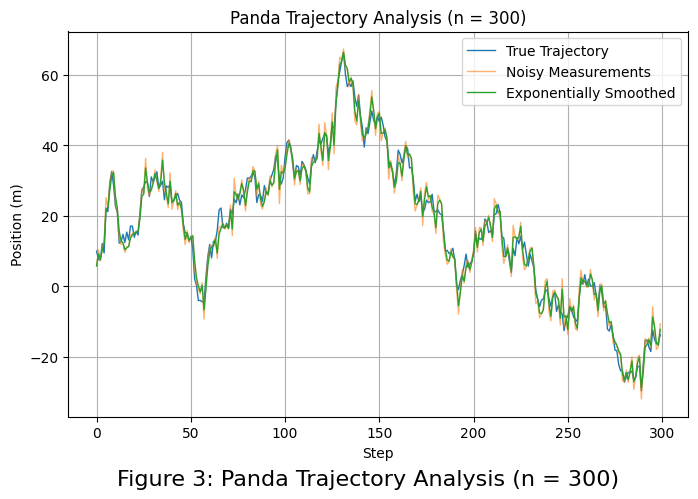

In [491]:
smoothed_1 = exponential_smoothing(z_1, alpha_1)

plt.figure(figsize=(8,5))
plt.plot(X_1, label='True Trajectory', linewidth=1)
plt.plot(z_1, label='Noisy Measurements', alpha=0.6, linewidth=1)
plt.plot(smoothed_1, label='Exponentially Smoothed', linewidth=1)
plt.xlabel('Step')
plt.ylabel('Position (m)')
plt.title(f'Panda Trajectory Analysis (n = {300})')
plt.suptitle(f'Figure 3: Panda Trajectory Analysis (n = {300})', fontsize=16, y=0.005)
plt.legend()
plt.grid()
plt.show()

Fig 3 depicts the effect of exponential smoothing which reduces the short-term noise by minimizing the random fluctuations in measurements and maintaining the natural variations.

#### Exponential smoothing results for n = 3000

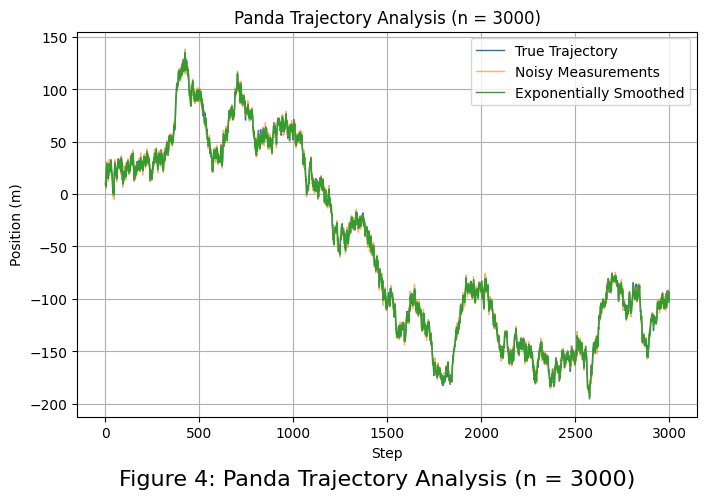

In [492]:
smoothed_2 = exponential_smoothing(z_2, alpha_2)

plt.figure(figsize=(8,5))
plt.plot(X_2, label='True Trajectory', linewidth=1)
plt.plot(z_2, label='Noisy Measurements', alpha=0.6, linewidth=1)
plt.plot(smoothed_2, label='Exponentially Smoothed', linewidth=1)
plt.xlabel('Step')
plt.ylabel('Position (m)')
plt.title(f'Panda Trajectory Analysis (n = {3000})')
plt.suptitle(f'Figure 4: Panda Trajectory Analysis (n = {3000})', fontsize=16, y=0.005)
plt.legend()
plt.grid()
plt.show()

By Fig 4, it is clear that with longer sequence the exponential smoothing preserves the overall drift ensuring the stability of the trajectory. 

## Part 2 – Shaky Cameras: Testing Under Harsh Conditions

Simulate panda movement with increased process noise and measurement noise to represent harsh conditions

### 1-2. Generate true trajectory with higher noise. Generate noisy measurements

Parameters:
- $\sigma_w^2 = 28^2$
- $\sigma_\eta^2 = 97^2$
- Initial position $X_1 = 10$ m

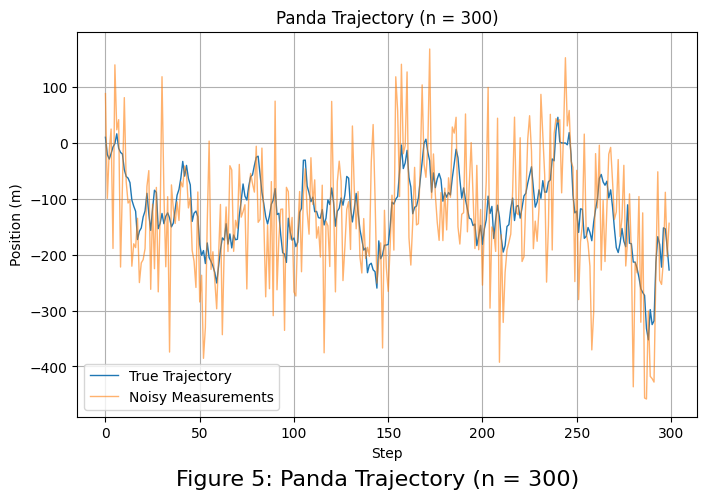

In [493]:
sigma_w2_shaky = 28**2
sigma_eta2_shaky = 97**2
init_pos = 10

res_shaky = simulate_random_walk(n_points=300 , sigma_w_sq=sigma_w2_shaky, sigma_eta_sq=sigma_eta2_shaky, init_pos=init_pos, fig_num=5)

## 3. Determine optimal smoothing coefficient
Use given noise variances and formula from Part I.

In [494]:
alpha_shaky = calc_optimal_alpha(sigma_w2_shaky, sigma_eta2_shaky)
print(f"Optimal smoothing coefficient alpha: {alpha_shaky:.4f}")

Optimal smoothing coefficient alpha: 0.2500


## 4. Find running mean window size M to equalize measurement-error contributions
$\sigma_{RM}^2 = \frac{\sigma_\eta^2}{M}$  
$\sigma_{ES}^2 = \frac{\sigma_\eta^2 \alpha}{2 - \alpha}$.  
Solve for $M$: 
$M = \frac{2 - \alpha}{\alpha}$

In [495]:
M = round((2 - alpha_shaky) / alpha_shaky)
print(f"Running mean window size M: {M}")

Running mean window size M: 7


## 5. Apply running mean and exponential smoothing on shaky measurements

In [496]:
def running_mean(data, window_size):
    if len(data) < window_size:
        return []

    N = len(data)
    smoothed = np.zeros(N)

    for i in range(N):
        smoothed[i] = np.mean(data[max(0, i - (window_size - 1) // 2):min(N, i + (window_size - 1) // 2)])

    return smoothed

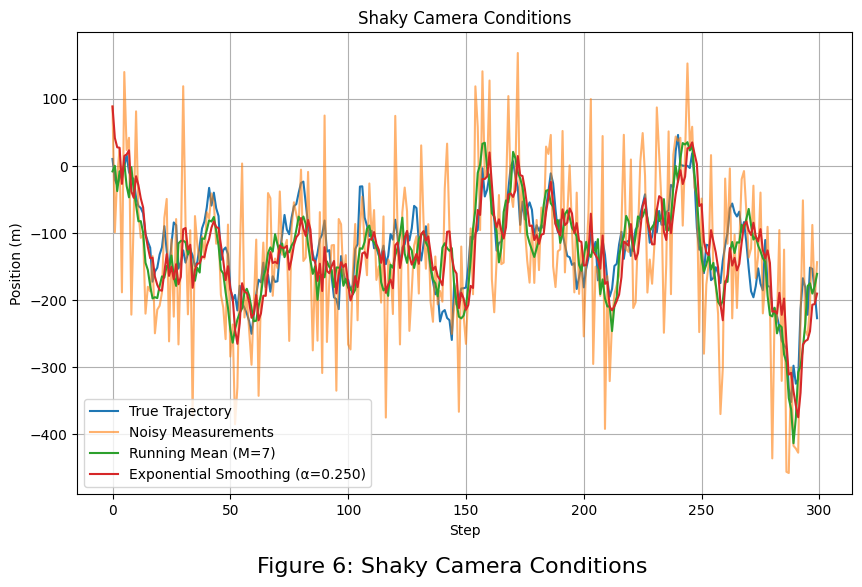

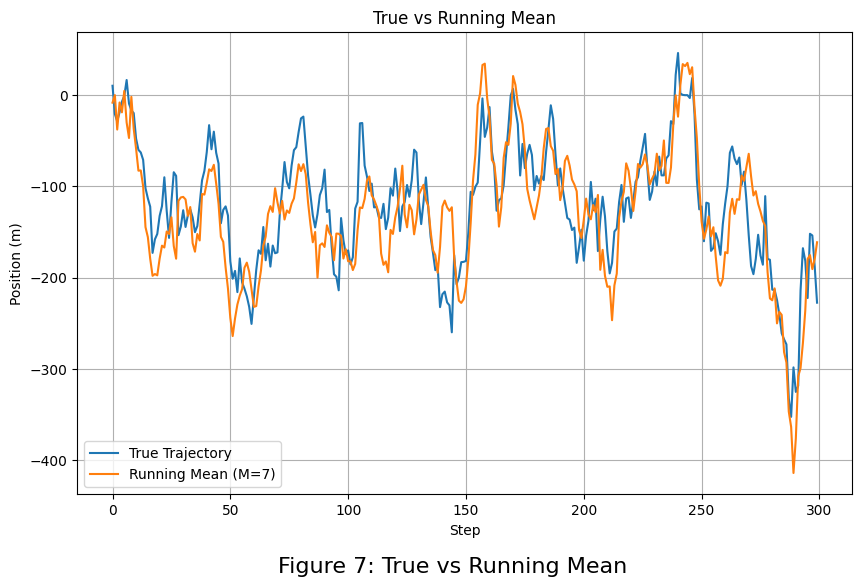

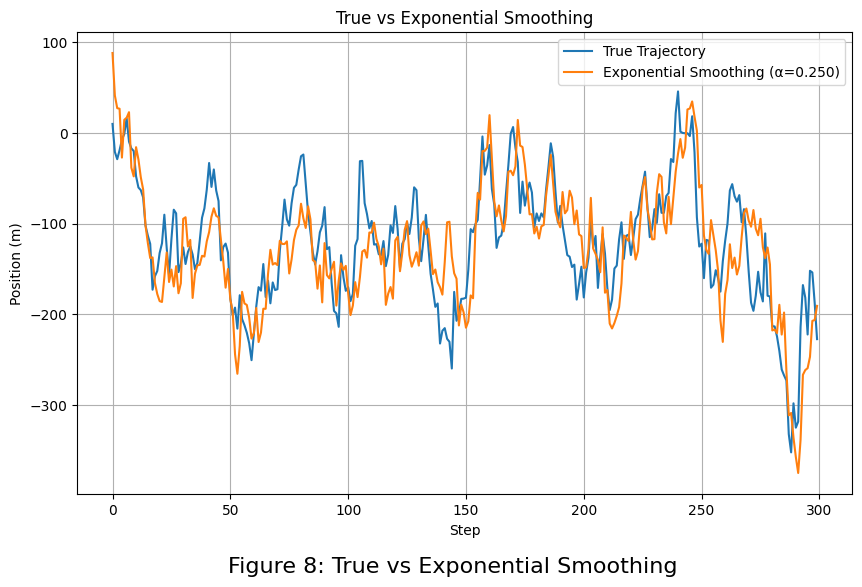

In [497]:
Xi, z, _, _ = res_shaky
es_smoothed = exponential_smoothing(z, alpha_shaky)
rm_smoothed = running_mean(z, M)

plt.figure(figsize=(10,6))
plt.plot(Xi, label='True Trajectory')
plt.plot(z, label='Noisy Measurements', alpha=0.6)
plt.plot(rm_smoothed, label=f'Running Mean (M={M})')
plt.plot(es_smoothed, label=f'Exponential Smoothing (α={alpha_shaky:.3f})')
plt.xlabel('Step')
plt.ylabel('Position (m)')
plt.title('Shaky Camera Conditions')
plt.suptitle(f'Figure 6: Shaky Camera Conditions', fontsize=16, y=0.005)
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(Xi, label='True Trajectory')
plt.plot(rm_smoothed, label=f'Running Mean (M={M})')
plt.xlabel('Step')
plt.ylabel('Position (m)')
plt.title('True vs Running Mean')
plt.suptitle(f'Figure 7: True vs Running Mean', fontsize=16, y=0.005)
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(Xi, label='True Trajectory')
plt.plot(es_smoothed, label=f'Exponential Smoothing (α={alpha_shaky:.3f})')
plt.xlabel('Step')
plt.ylabel('Position (m)')
plt.title('True vs Exponential Smoothing')
plt.suptitle(f'Figure 8: True vs Exponential Smoothing', fontsize=16, y=0.005)
plt.legend()
plt.grid()
plt.show()

## 6. Visual errors comparison

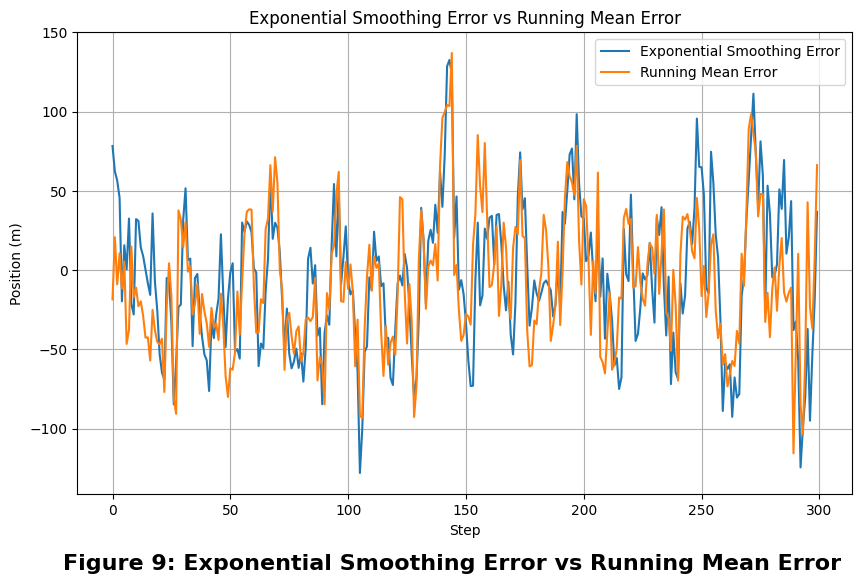

In [498]:
plt.figure(figsize=(10,6))
plt.plot(es_smoothed - Xi, label='Exponential Smoothing Error')
plt.plot(rm_smoothed - Xi, label=f'Running Mean Error')
plt.xlabel('Step')
plt.ylabel('Position (m)')
plt.title('Exponential Smoothing Error vs Running Mean Error')
plt.suptitle("Figure 9: Exponential Smoothing Error vs Running Mean Error", fontsize=16, fontweight='bold', y=0.01)
plt.legend()
plt.grid()
plt.show()

Fig 9 shows the comparison of exponential smoothing and running mean involving the true trajectory and noisy measurements. It can be seen that running mean provides a more stable and stable estimation than exponential smoothing which involves a lag

In [499]:
rmse_es = np.sqrt(np.sum((es_smoothed - Xi)**2) / (len(Xi) - 1))
rmse_rm = np.sqrt(np.sum((rm_smoothed - Xi)**2) / (len(Xi) - 1))

print(f"RMSE for exponential smoothing: {rmse_es:.4f}")
print(f"RMSE for running mean: {rmse_rm:.4f}")

RMSE for exponential smoothing: 45.1080
RMSE for running mean: 42.7269


## Learning Log

| Activity                     | Key Understanding                                                 | Insights                                             | Final Takeaway                                |
|------------------------------|-------------------------------------------------------------------|-----------------------------------------------------|-----------------------------------------------|
| Panda’s random walk trajectory | A random walk represents unpredictable but continuous movement over time | Variance directly affects the spread and smoothness of the trajectory | Random walk modeling effectively simulates natural, stochastic motion |
| Addition of measurement noise | Effect of measurement noise distorts the true trajectory         | Higher noise levels complicate estimation            | Accurate tracking requires noise filtering or smoothing |
| Identified values of σw² and ση² | Statistical estimation is reliable with larger datasets          | Small data leads to larger deviations                 | Greater sample size means high accuracy        |
| Calculated the optimal smoothing coefficient (α) | Ratio of process to measurement noise determines the smoothing rate | Lower α stabilizes the estimate                        | -                                             |
| Equivalent window size (M)   | Relation between exponential smoothing and moving average         | Running mean provides a better smoothing along with a lag | Matching M and α helps compare both methods objectively |
| Comparison of both methods   | Performance of both filters depend on noise intensity and data variability | Running mean provides more stable estimation          | -                                             |
